
## Forecasting US- Consumer price index

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tools.eval_measures import mse, rmse, meanabs

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing


from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL


import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_excel("CPI.xlsx", index_col="Date", parse_dates=True)

In [3]:
df.head()



,CPI
Date,
1947-01-01,21.48
1947-02-01,21.62
1947-03-01,22.00
1947-04-01,22.00
1947-05-01,21.95


In [4]:
df.index.freq = "MS"
df.index

DatetimeIndex(['1947-01-01', '1947-02-01', '1947-03-01', '1947-04-01',
               '1947-05-01', '1947-06-01', '1947-07-01', '1947-08-01',
               '1947-09-01', '1947-10-01',
               ...
               '2023-08-01', '2023-09-01', '2023-10-01', '2023-11-01',
               '2023-12-01', '2024-01-01', '2024-02-01', '2024-03-01',
               '2024-04-01', '2024-05-01'],
              dtype='datetime64[ns]', name='Date', length=929, freq='MS')

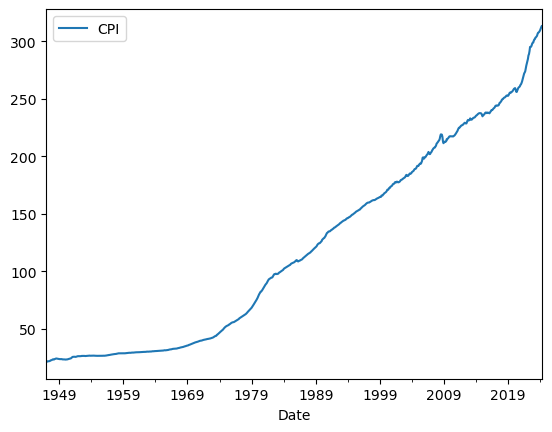

In [5]:
df.plot();

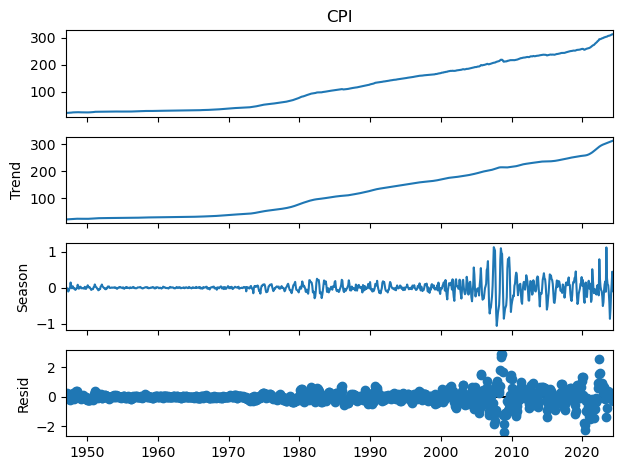

In [6]:
STL(df['CPI'], period=12).fit().plot();

In [7]:
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)
    
    if kpsstest[1] <= 0.05:
        print("Reject the null hypothesis")
        print("Data has  unit root and is therefore non-stationary")
    else:
        print("Fail to reject the null hypothesis")
        print("Data has no unit root and is stationary")

In [8]:
kpss_test(df["CPI"])

Results of KPSS Test:
Test Statistic            4.880132
p-value                   0.010000
Lags Used                18.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
Reject the null hypothesis
Data has  unit root and is therefore non-stationary


In [9]:
mid = len(df)-24
df_train = df.iloc[:mid]
df_test = df.iloc[mid:]

#### Exponential smoothing

In [10]:
mod_fit_hw = ExponentialSmoothing(df_train["CPI"], trend='additive').fit()

In [11]:
test_predictions_hw = mod_fit_hw.forecast(24).rename('Holt Exponential Smoothing')

In [12]:
import numpy as np
alphas = np.linspace(0.01, 0.99, num=50)
best_alpha = None
best_mse = float('inf')

for alpha in alphas:
    model = ExponentialSmoothing(df_train["CPI"],trend='additive').fit(smoothing_level=alpha)
    forecast = model.forecast(steps=len(df_test["CPI"]))
    Mse = mse(df_test["CPI"], forecast)
    if  Mse < best_mse:
        best_mse = Mse
        best_alpha = alpha

In [13]:
# Forecast future values
final_model = ExponentialSmoothing(df_train["CPI"],trend='additive').fit(smoothing_level=best_alpha)
future_forecast = final_model.forecast(steps=24).rename("Holts Exponential smoothing (Tuning)")

In [14]:
MSE_hw = mse(df_test['CPI'],test_predictions_hw)
RMSE_hw = rmse(df_test['CPI'],test_predictions_hw)
Meababs_hw = meanabs(df_test['CPI'],test_predictions_hw)

MSE_T = mse(df_test['CPI'],future_forecast)
RMSE_T = rmse(df_test['CPI'],future_forecast)
Meababs_T = meanabs(df_test['CPI'],future_forecast)

print("")
print(f"The Holt's Exponential MSE is {MSE_hw:.3f}")
print(f"The Holt's Exponential RMSE is {RMSE_hw:.3f}")
print(f"The Holt's Exponential MAE is {Meababs_hw:.3f}")
print("")

print(f"The Holt's Exponential MSE(Tuning) is {MSE_T:.3f}")
print(f"The Holt's Exponential RMSE(Tuning) is {RMSE_T:.3f}")
print(f"The Holt's Exponential MAE(Tuning) is {Meababs_T:.3f}")



The Holt's Exponential MSE is 273.404
The Holt's Exponential RMSE is 16.535
The Holt's Exponential MAE is 14.073

The Holt's Exponential MSE(Tuning) is 21.461
The Holt's Exponential RMSE(Tuning) is 4.633
The Holt's Exponential MAE(Tuning) is 3.962


<Axes: xlabel='Date'>

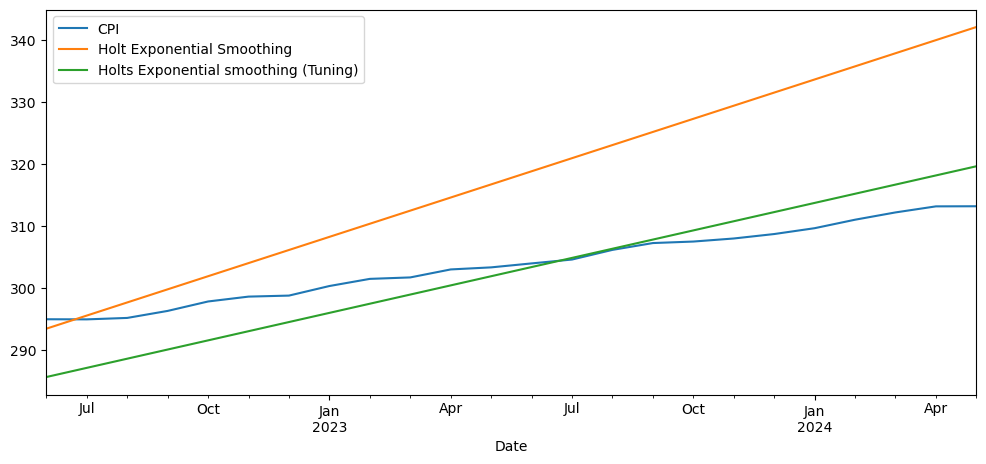

In [15]:
df_test["CPI"].plot(legend=True, figsize=(12,5), label="CPI")
test_predictions_hw.plot(legend=True)
future_forecast.plot(legend=True)
#plt.ylim(250, 350)  # Adjust the values as needed
#plt.show()


### ARIMA Model

In [16]:
from pmdarima import auto_arima

In [17]:
auto_arima(df["CPI"], start_p=2, start_q=2, max_p=40,max_d=5,max_q=40).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  929
Model:               SARIMAX(0, 2, 3)   Log Likelihood                -386.397
Date:                Sun, 14 Jul 2024   AIC                            780.793
Time:                        17:25:27   BIC                            800.121
Sample:                    01-01-1947   HQIC                           788.166
                         - 05-01-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4232      0.013    -31.455      0.000      -0.450      -0.397
ma.L2         -0.4077      0.016    -25.572      0.000      -0.439      -0.376
ma.L3         -0.0715      0.020     -3.598      0.000      -0.110      -0.033
sigma2         0.1345      0.002     55.436      0.000       0.130       0.139
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              7429.89
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):              51.16   Skew:                            -1.10
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

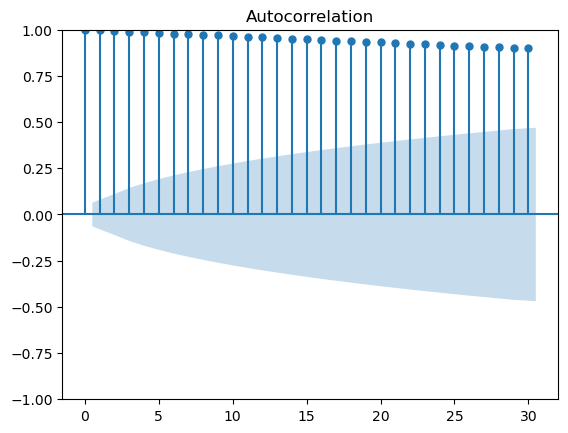

In [18]:
plot_acf(df["CPI"]);

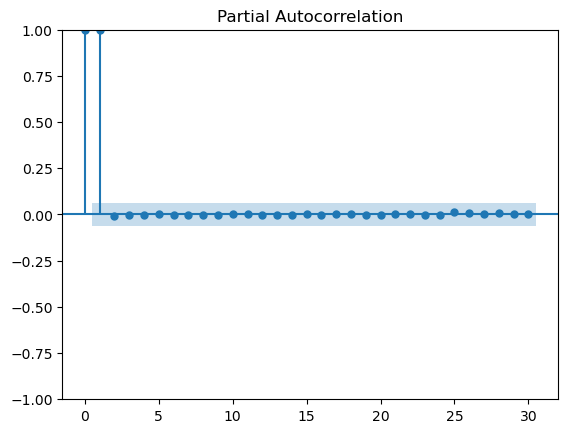

In [19]:
plot_pacf(df["CPI"]);

In [20]:
from statsmodels.tsa.arima.model import ARIMA
#from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
#from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders

In [21]:
arima_model = ARIMA(df_train['CPI'],order=(0,2,3))
arima_results = arima_model.fit()
arima_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    CPI   No. Observations:                  905
Model:                 ARIMA(0, 2, 3)   Log Likelihood                -329.088
Date:                Sun, 14 Jul 2024   AIC                            666.175
Time:                        17:25:35   BIC                            685.398
Sample:                    01-01-1947   HQIC                           673.517
                         - 05-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3930      0.015    -25.642      0.000      -0.423      -0.363
ma.L2         -0.3574      0.018    -20.237      0.000      -0.392      -0.323
ma.L3         -0.1176      0.025     -4.702      0.000      -0.167      -0.069
sigma2         0.1212      0.002     53.365      0.000       0.117       0.126
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):              7896.31
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):              44.81   Skew:                            -1.08
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [22]:
arima_test_pred = arima_results.get_forecast(steps=24)

In [23]:
MSE_arima = mse(df_test["CPI"], arima_test_pred.predicted_mean )
RMSE_arima = rmse(df_test["CPI"], arima_test_pred.predicted_mean )
MAE_arima = meanabs(df_test["CPI"], arima_test_pred.predicted_mean )

print(f"MSE is {MSE_arima:.3f}")
print(f"RMSE is {RMSE_arima:.3f}")
print(f"MAE is {MAE_arima:.3f}")

MSE is 95.023
RMSE is 9.748
MAE is 8.312


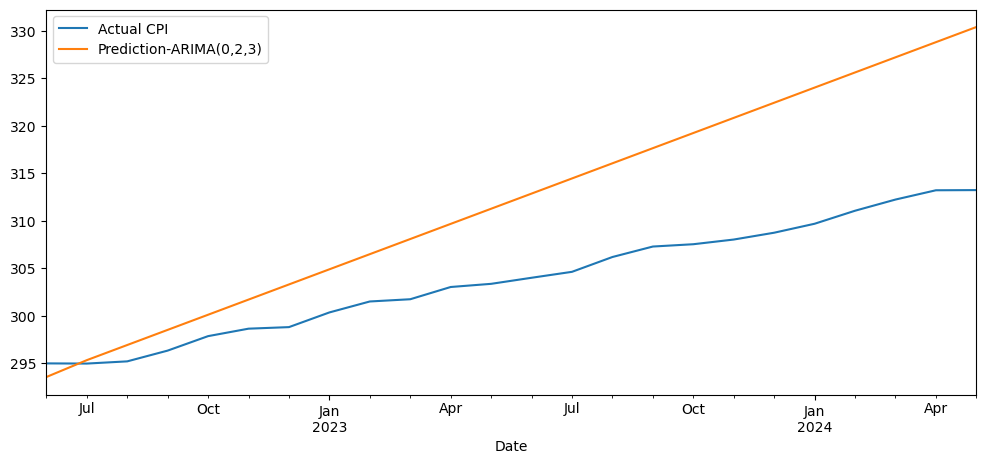

In [24]:
df_test["CPI"].plot(legend=True, label = "Actual CPI",figsize=(12,5));
arima_test_pred.predicted_mean.plot(legend=True, label="Prediction-ARIMA(0,2,3)");
#plt.ylim(250, 350)  # Adjust the values as needed

plt.show()


### LSTM

In [25]:

import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if len(data.shape) == 1 else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [("var%d(t-%d)" % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [("var%d(t)" % (j + 1)) for j in range(n_vars)]
        else:
            names += [("var%d(t+%d)" % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg




In [26]:
mid = len(df)-37
train = df.iloc[:mid]
test = df.iloc[mid:]

train.diff(periods=1)

train_shifted = train.shift(periods=1)
train_diff = train - train_shifted

test_shifted = test.shift(periods=1)
test_diff = test - test_shifted

In [27]:
scaler = MinMaxScaler(feature_range=(-1, 1))

train_diffnorm = scaler.fit_transform(train_diff.values.reshape(-1, 1))
test_diffnorm = scaler.transform(test_diff.values.reshape(-1, 1))

train_df = series_to_supervised(train_diffnorm, n_in=12, n_out=1).values
test_df = series_to_supervised(test_diffnorm, n_in=12, n_out=1).values

# ---

X_train, y_train = train_df[:, :-1], train_df[:, -1]
X_test, y_test = test_df[:, :-1], test_df[:, -1]

X_train = torch.from_numpy(X_train).type(torch.Tensor)
X_test = torch.from_numpy(X_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor).view(-1)
y_test = torch.from_numpy(y_test).type(torch.Tensor).view(-1)

X_train = X_train.view([X_train.shape[0], X_train.shape[1], 1])
X_test = X_test.view([X_test.shape[0], X_test.shape[1], 1])




In [28]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out




In [29]:
model = LSTM(input_dim=1, hidden_dim=186, output_dim=1, num_layers=2)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 200

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    out = model(X_train).reshape(-1, )
    loss = loss_fn(out, y_train)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, Loss: {loss.item()}")



Epoch: 0, Loss: 0.10190538316965103
Epoch: 10, Loss: 0.015582560561597347
Epoch: 20, Loss: 0.015368904918432236
Epoch: 30, Loss: 0.015248329378664494
Epoch: 40, Loss: 0.01521220337599516
Epoch: 50, Loss: 0.015070237219333649
Epoch: 60, Loss: 0.014923637732863426
Epoch: 70, Loss: 0.014745487831532955
Epoch: 80, Loss: 0.014487165957689285
Epoch: 90, Loss: 0.014009086415171623
Epoch: 100, Loss: 0.01380773913115263
Epoch: 110, Loss: 0.0136482585221529
Epoch: 120, Loss: 0.013540276326239109
Epoch: 130, Loss: 0.013434506952762604
Epoch: 140, Loss: 0.013299277052283287
Epoch: 150, Loss: 0.013123691082000732
Epoch: 160, Loss: 0.012888557277619839
Epoch: 170, Loss: 0.012561879120767117
Epoch: 180, Loss: 0.012076117098331451
Epoch: 190, Loss: 0.01123757753521204


In [31]:
model.eval()
y_pred = model(X_test).reshape(-1, )

y_diff = scaler.inverse_transform(y_pred.detach().numpy().reshape(-1, 1)).flatten()
#y_original = y_diff + test_shifted.values[13:]
y_original = np.add(y_diff.reshape(-1, 1), test_shifted[13:].values.reshape(-1, 1))


In [32]:

test_loss = loss_fn(y_pred, y_test)
print(f"Test Loss (MSE): {test_loss.item()}")

Test Loss (MSE): 0.07757862657308578


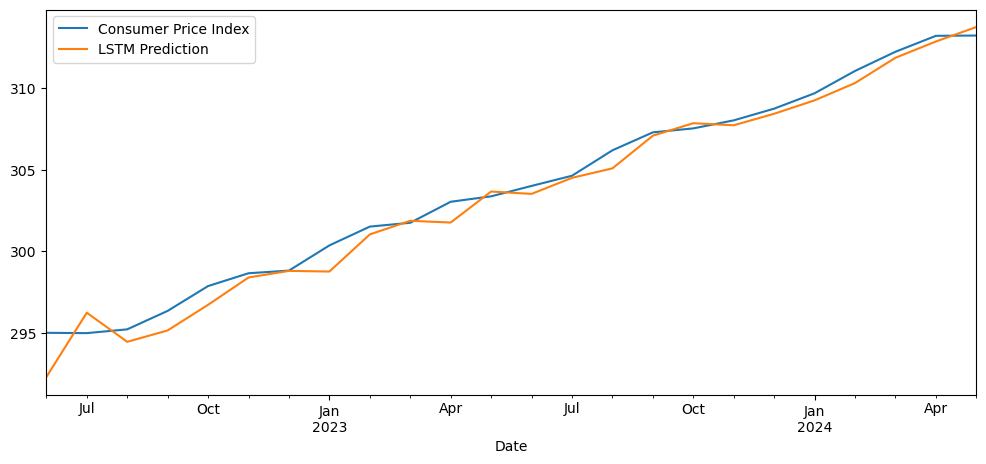

In [34]:
test_plot = test[13:]
test_plot["Y_Pred"] = y_original
test_plot["CPI"].plot(legend=True, figsize=(12,5), label="Consumer Price Index")
test_plot["Y_Pred"].plot(legend=True, label="LSTM Prediction");


In [35]:
test_plot

,CPI,Y_Pred
Date,,
2022-06-01,294.996,292.285358
2022-07-01,294.977,296.228946
2022-08-01,295.209,294.443846
2022-09-01,296.341,295.142775
2022-10-01,297.863,296.713853
2022-11-01,298.648,298.388488
2022-12-01,298.812,298.793534
2023-01-01,300.356,298.753981
2023-02-01,301.509,301.031143
